# TAR: Taller de Aprendizaje por Refuerzo 2025
## Laboratorio 5: Gymnasium + stable_baselines3

### Stable Baselines3 (SB3) es una libreria algoritmos de reinforcement learning implementada en PyTorch. 

*Ejecutar esta celda solo la primera vez (si estan usando un entorno local - es la misma del lab 4) para descargar e instalar los paquetes necesarios. Si ejecutan el notebook en colab tendran que ejecutarla cada vez que reinicien el kernel*

In [1]:
# !apt install swig cmake
# !pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit1/requirements-unit1.txt

In [2]:
import subprocess

print(subprocess.run(["cmake", "--version"], capture_output=True).stdout.decode())
print(subprocess.run(["swig", "-version"], capture_output=True).stdout.decode())

cmake version 4.0.2

CMake suite maintained and supported by Kitware (kitware.com/cmake).


SWIG Version 4.3.1

Compiled with x86_64-w64-mingw32-g++ [x86_64-w64-mingw32]

Configured options: +pcre

Please see https://www.swig.org for reporting bugs and further information



In [3]:
!pip install Box2D 

In [4]:
import Box2D
print(Box2D.__version__)

2.3.10


In [5]:
# !pip install "torch>=1.11" "gymnasium==0.28.1" huggingface-hub~=0.8 wasabi 

In [6]:
# !pip install gymnasium 

In [7]:
# !pip install pygame --only-binary :all: 

In [8]:
# !pip install stable-baselines3==2.0.0a5 huggingface_sb3 swig 

In [9]:
# !pip install ipywidgets 

In [10]:
import importlib
import sys

# Paquetes a verificar con sus nombres de importación
required_packages = {
    "gymnasium": "gymnasium",
    "Box2D": "Box2D",
    "pygame": "pygame",
    "stable_baselines3": "stable_baselines3",
    "huggingface_sb3": "huggingface_sb3",
    "swig": "swig"
}

print("🔎 Verificando dependencias:\n")

for name, module in required_packages.items():
    try:
        mod = importlib.import_module(module)
        version = getattr(mod, "__version__", "✅ (versión no disponible)")
        print(f"{name:20} ➜ ✅ Encontrado, versión: {version}")
    except ModuleNotFoundError:
        print(f"{name:20} ➜ ❌ No encontrado")
    except Exception as e:
        print(f"{name:20} ➜ ⚠️ Error: {e}")

print("\n✅ Verificación completa.")

🔎 Verificando dependencias:

gymnasium            ➜ ✅ Encontrado, versión: 0.28.1
Box2D                ➜ ✅ Encontrado, versión: 2.3.10
pygame               ➜ ✅ Encontrado, versión: 2.6.1
stable_baselines3    ➜ ✅ Encontrado, versión: 2.0.0a5
huggingface_sb3      ➜ ✅ Encontrado, versión: ✅ (versión no disponible)
swig                 ➜ ✅ Encontrado, versión: 4.3.1

✅ Verificación completa.


In [11]:
import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode="rgb_array")
obs, info = env.reset()
print("Ambiente cargado 🎯")

Ambiente cargado 🎯


In [12]:
!python --version

Python 3.11.11


#### IMPORTS

In [13]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from comet_ml import Experiment
from stable_baselines3.common.callbacks import BaseCallback

## Ejercicio 1. Lunar Landing

En este ejemplo entrenaremos un agente que aprenda a aterrizar correctamente una nave en la luna.
Doc del ambiente: https://gymnasium.farama.org/environments/box2d/lunar_lander/


#### 1.1 Estudiar el ambiente

In [14]:
#TODO Definir el ambiente `LunarLander-v2` e imprimir el tamaño del espacio de observación y del espacio de acciones.

env = gym.make("LunarLander-v2", continuous=False, gravity=-1.62,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
env.reset()

tamaño_obs = env.observation_space.shape
print("Tamaño del espacio de observación: ", tamaño_obs)

tamaño_acciones = env.action_space.n
print("Tamaño del espacio de acción: ", tamaño_acciones)

Tamaño del espacio de observación:  (8,)
Tamaño del espacio de acción:  4


El vector de **observación** corresponde a los siguientes parámetros de la nave:
- posición en x
- posición en y
- velocidad lineal en x
- velocidad lineal en y
- ángulo
- velocidad angular
- variable binaria que representa si la pata izquierda toca el suelo o no
- variable binaria que representa si la pata derecha toca el suelo o no


Por otro lado, el espacio de **acciones** es:

- Acción 0: no hacer nada
- Acción 1: Encender el motor lateral izquierdo (empuja a la derecha)
- Acción 2: Encender el motor principal (empuja hacia arriba)
- Acción 3: Encender el motor lateral derecho (empuja a la izquierda)


Función de **recompensa**:

  Después de cada paso, se otorga una recompensa. La recompensa total de un episodio es la suma de las recompensas de todos los pasos dentro de ese episodio.

  Para cada paso, la recompensa:

- se incrementa/decrementa cuanto más cerca/más lejos esté la nave de la zona de aterrizaje
- se incrementa/decrementa cuanto más lento/más rápido se mueva la nave
- se decrementa cuanto más se incline la nave hacia los costados
- se incrementa por 10 puntos para cada pata que toque el piso
- se decrementa por 0.03 puntos por cada frame en que se use motor lateral
- se decrementa por 0.3 puntos por cada frame en que se use el motor principal

El episodio recibe una recompensa adicional de -100 si choca y +100 si aterriza de manera segura.

Un episodio termina si:
- la nave choca (el cuerpo principal, no las patas, de la nave entra en contacto con la luna)
- la nave se sale del área visible (x sale de su rango)
- la nave está en "modo dormido" (un cuerpo en "modo dormido" es uno que no se mueve y no choca con ningún otro cuerpo)

El episodio se considera una solución si obtiene al menos 200 puntos.

##### Multi-procesamiento
A continuación se vectoriza el ambiente para poder paralelizar el entrenamiento, (por suerte la libreria nos da las heramientas para lograr esto sin mucho esfuerzo)

In [15]:
from stable_baselines3.common.env_util import make_vec_env

# Create the environment
env = make_vec_env('LunarLander-v2', n_envs=16)

#### 1.2 Definir el modelo usando el modelo [Proximal Policy Optimization(PPO) de stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)

Leer la documentación y variar diferentes hiperparámetros como `batch_size`, `gamma`, entre otros.

¿Que tipo de metodo implementa?

##### RESPUESTA --> 
PPO es un algoritmo de optimización de políticas:

* Es on-policy (aprende de las acciones que realmente toma).
* Pertenece a la familia de métodos de policy gradient.
* Es una mejora de TRPO (Trust Region Policy Optimization), pero más simple.
* Usa técnicas como clipping para limitar cuánto puede cambiar la política en cada actualización y así estabilizar el entrenamiento.

In [16]:
# !pip install comet-ml

In [17]:
# Inicialización del experimento (reemplazá con tu clave y proyecto)
experiment = Experiment(
    api_key="olHeoTp6comM3x5X987X7RuMm",
    project_name="lab4",
    workspace="tar"
)

experiment.set_name("PPO")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tar/lab4/301da4d11c2a47fbb9c86b82484273ab

COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


In [18]:
from stable_baselines3 import PPO

# Definición de hiperparámetros
hyperparams = {
    "policy": "MlpPolicy",
    "batch_size": 64,
    "gamma": 0.99,
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 3e-4
}

# Loggear en Comet
experiment.log_parameters(hyperparams)

# Crear el modelo
model = PPO(
    policy=hyperparams["policy"],
    env=env,
    verbose=1,
    batch_size=hyperparams["batch_size"],
    gamma=hyperparams["gamma"],
    n_steps=hyperparams["n_steps"],
    ent_coef=hyperparams["ent_coef"],
    learning_rate=hyperparams["learning_rate"]
)

Using cpu device


In [20]:
class CometCallback(BaseCallback):
    def __init__(self, experiment, verbose=0):
        super().__init__(verbose)
        self.experiment = experiment
        self.episode_rewards = None

    def _on_training_start(self) -> None:
        n_envs = self.training_env.num_envs
        self.episode_rewards = [[] for _ in range(n_envs)]

    def _on_step(self) -> bool:
        rewards = self.locals["rewards"]
        dones = self.locals["dones"]

        for i, (r, done) in enumerate(zip(rewards, dones)):
            self.episode_rewards[i].append(r)
            if done:
                total = sum(self.episode_rewards[i])
                self.experiment.log_metric("episode_reward", total, step=self.num_timesteps)
                self.episode_rewards[i] = []

        return True


In [21]:
# Entrenar por 1.000.000 timesteps

model.learn(total_timesteps=1000000, callback=CometCallback(experiment))

model_name = "ppo-LunarLander-v2"

# Guardar el modelo
model.save(model_name)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 90.7     |
|    ep_rew_mean     | -194     |
| time/              |          |
|    fps             | 4538     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 32768    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 93.5        |
|    ep_rew_mean          | -146        |
| time/                   |             |
|    fps                  | 2021        |
|    iterations           | 2           |
|    time_elapsed         | 32          |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.007492196 |
|    clip_fraction        | 0.0571      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.001731813 |
|    learning_rate        | 0.

#### 1.3 Evaluación del modelo:

¿Como podemos evaluar si el agente aprendió a aterrizar la nave?

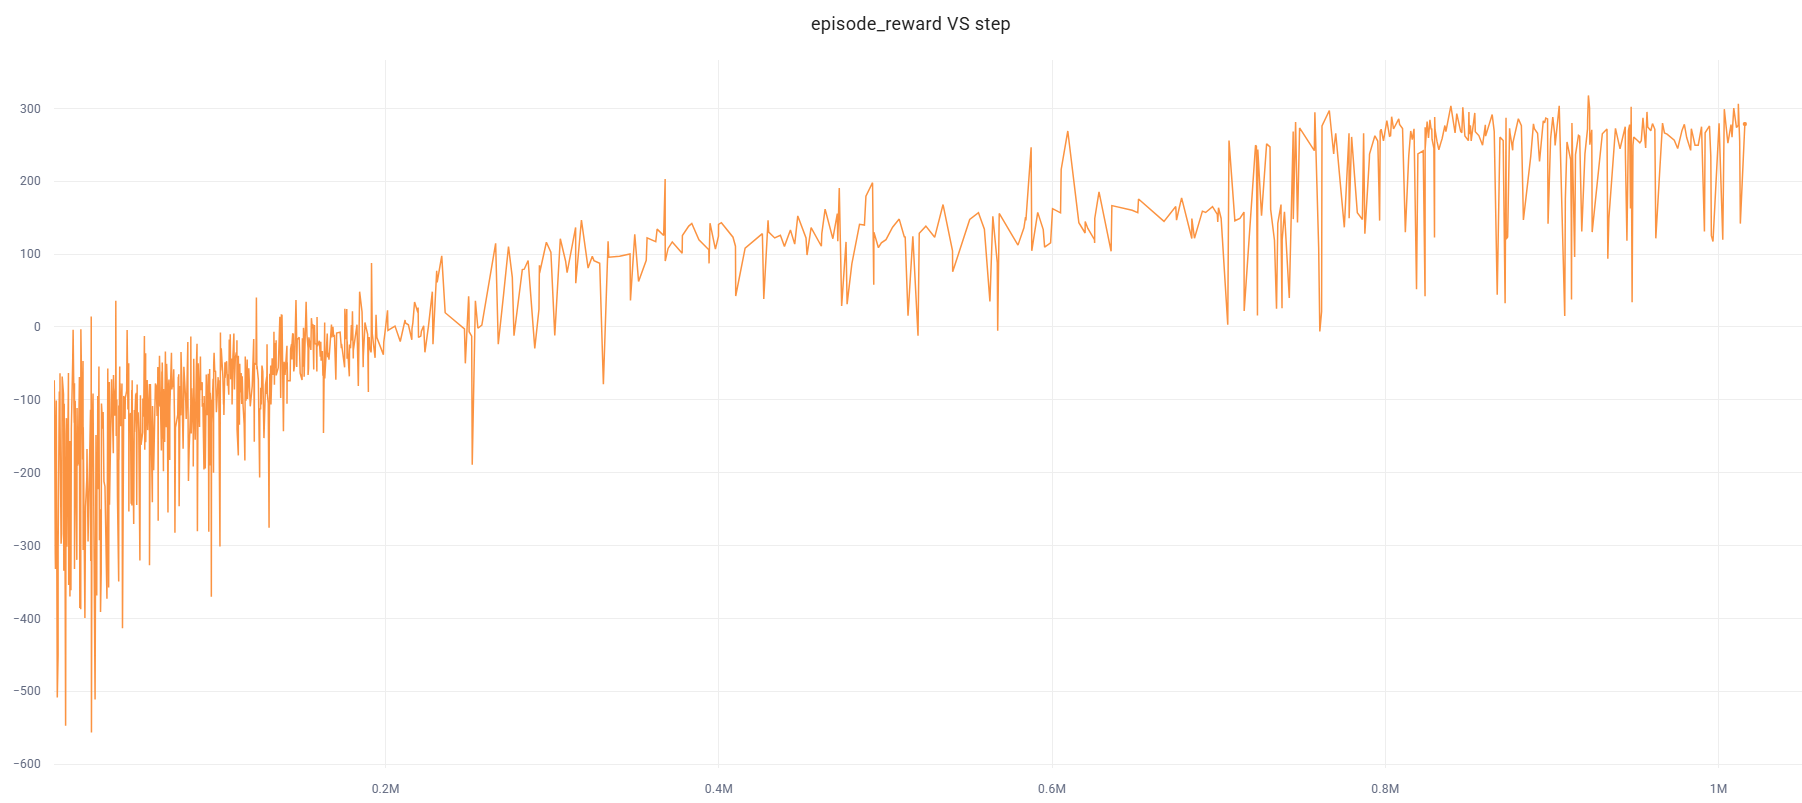

##### RESPUESTA --> 

Una posibilidad para evaluar si el agente aprendió a aterrizar la nave, es usarlo para explotar en algunos episodios y luego promediar sus recompensas al final de cada uno de los episodios. Si esta media es mayor o igual a 200 significaría que en media el agente dio una buena solución al problema del aterrizaje.

In [27]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

eval_env = Monitor(gym.make("LunarLander-v2", render_mode='rgb_array'))
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

mean_reward=248.40 +/- 40.4201541218413


**Conclusión:** Como la media es mayor que 200, entonces se puede decir que el agente aprendió a aterrizar la nave.

#### 1.4 Correr el agente entrenado y guardar un video del aterrizaje

si esto da error de timeout pueden generar un .py y correrlo desde consola para guardar el video

In [26]:
# !pip install moviepy

In [25]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.wrappers import RecordVideo

# Load the trained model
model = PPO.load("ppo-LunarLander-v2")

# Create the environment with the proper render_mode for video recording
env = DummyVecEnv([lambda: RecordVideo(gym.make("LunarLander-v2", render_mode="rgb_array"), "./videos/PPO", episode_trigger=lambda x: True)])

# Reset the environment to get the initial observation
obs = env.reset()
done = False

# Play one episode to capture the video
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    
# Close the environment to save the video file
env.close()

print("Video saved in the './videos' directory.")


C:\Users\E090219\AppData\Local\miniconda3\envs\tar\Lib\site-packages\gymnasium\wrappers\record_video.py:87: UserWarning: WARN: Overwriting existing videos at C:\Users\E090219\Desktop\TAR\Reinforcement_learning\Entregas\videos\PPO folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video C:\Users\E090219\Desktop\TAR\Reinforcement_learning\Entregas\videos\PPO\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\E090219\Desktop\TAR\Reinforcement_learning\Entregas\videos\PPO\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\E090219\Desktop\TAR\Reinforcement_learning\Entregas\videos\PPO\rl-video-episode-0.mp4
MoviePy - Building video C:\Users\E090219\Desktop\TAR\Reinforcement_learning\Entregas\videos\PPO\rl-video-episode-1.mp4.
MoviePy - Writing video C:\Users\E090219\Desktop\TAR\Reinforcement_learning\Entregas\videos\PPO\rl-video-episode-1.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\E090219\Desktop\TAR\Reinforcement_learning\Entregas\videos\PPO\rl-video-episode-1.mp4
Video saved in the './videos' directory.


## Ejercicio 2. Cart Pole

En este ejemplo entrenaremos un agente que aprenda a equilibrar un poste sobre un carrito que se mueve sobre una linea.
Doc del ambiente: https://gymnasium.farama.org/environments/classic_control/cart_pole/


#### 2.1 Estudiar el ambiente:

¿Como son el espacio de acciones y el espacio de estados?

##### RESPUESTA -->



In [ ]:
#TODO Definir el ambiente e imprimir el tamaño del espacio de observación y del espacio de acciones.


#### 2.2 Definir el modelo usando el modelo - A2C de stable_baselines3

¿Que tipo de metodo implementa?

##### RESPUESTA --> 

In [ ]:
#TODO definir el modelo A2C 

#### 2.3 Vectorizar el ambiente y entrenar el modelo

In [ ]:
#TODO vectorizar el ambiente y entrenar el agente A2C

#...

model_name = "A2C-CartPole-v1"

# Guardar el modelo
#model.save(model_name)

##### ¿Comó se si mi modelo aprendió?

##### ¿Comó son las recompensas?

### RESPUESTA:

#### 2.4 Evaluar el agente


In [ ]:
import gymnasium as gym
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.wrappers import RecordVideo

# Load the trained model
model = A2C.load("A2C-CartPole-v1")

# Create the environment with the proper render_mode for video recording
env = DummyVecEnv([lambda: RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos/A2C", episode_trigger=lambda x: True)])

# Reset the environment to get the initial observation
obs = env.reset()
done = False

# Play one episode to capture the video
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    
# Close the environment to save the video file
env.close()

print("Video saved in the './videos' directory.")